### Carga de datos

In [1]:
import pandas as pd
import numpy as np

# Establecer la semilla aleatoria para NumPy
np.random.seed(40)

data_train=pd.read_excel('Datos_train.xlsx',index_col=0)
data_test = pd.read_excel('Datos_test.xlsx',index_col=0)  
etiq_verd_train=data_train[['Etiq']]
etiq_verd_test=data_test[['Etiq']]
data_train = data_train[['Temperatura','Consumo_Lavanderia', 'Consumo_Cocina', 
                         'Resto_Consumo', 'Habitantes']]
data_test = data_test[['Temperatura','Consumo_Lavanderia', 'Consumo_Cocina', 
                         'Resto_Consumo', 'Habitantes']]

print(data_train.head())
print(data_test.head())

data_train=np.array(data_train)
data_test=np.array(data_test)

     Temperatura  Consumo_Lavanderia  Consumo_Cocina  Resto_Consumo  \
518     0.395349            0.246374        0.331337       0.111447   
601     0.395349            0.198473        0.273396       0.490744   
602     0.139535            0.167176        0.252471       0.490744   
968     0.418605            0.317557        0.151627       0.576502   
325     0.651163            0.231298        0.182481       0.492255   

     Habitantes  
518      0.5625  
601      0.2500  
602      0.2500  
968      0.5625  
325      0.3750  
      Temperatura  Consumo_Lavanderia  Consumo_Cocina  Resto_Consumo  \
847      0.604651            0.203817        0.187748       0.219500   
298      0.232558            0.360687        0.181398       0.105780   
197      0.418605            0.243321        0.338336       0.170759   
1065     0.441860            0.244656        0.129014       0.223649   
881      0.697674            0.298664        0.159391       0.408765   

      Habitantes  
847       0.4

### Entrenamiento del modelo

<IPython.core.display.Javascript object>


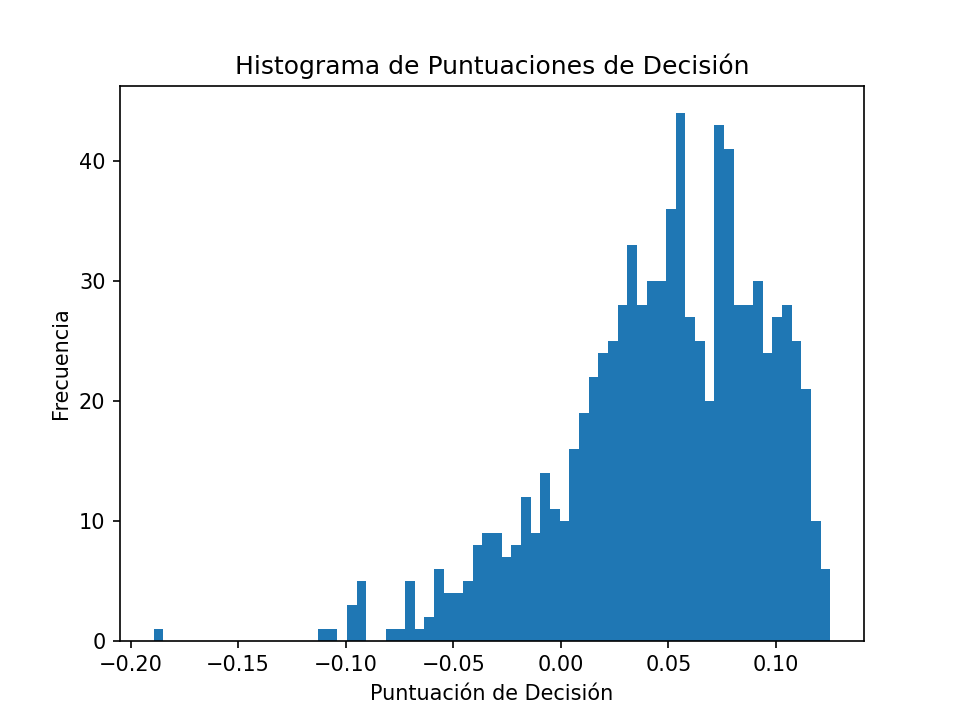

In [20]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Inicializa el modelo Isolation Forest
iForest = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', random_state=42) 

# Ajusta el modelo a los datos
iForest.fit(data_train)

# Calcula las puntuaciones de anomalía para cada observación
scores_train = iForest.decision_function(data_train)

plt.hist(scores_train, bins=70)
plt.xlabel('Puntuación de Decisión')
plt.ylabel('Frecuencia')
plt.title('Histograma de Puntuaciones de Decisión')
plt.show()

### Análisis de TDA, TFA, Precisión y Umbral

C:\Users\djime\AppData\Local\Temp\ipykernel_36940\2600863428.py:17: RuntimeWarning: invalid value encountered in scalar divide
  PREC=VP/(VP+FP) # Describe a las predicciones positivas correctas (PrediccPosit=VP+FP)


<IPython.core.display.Javascript object>


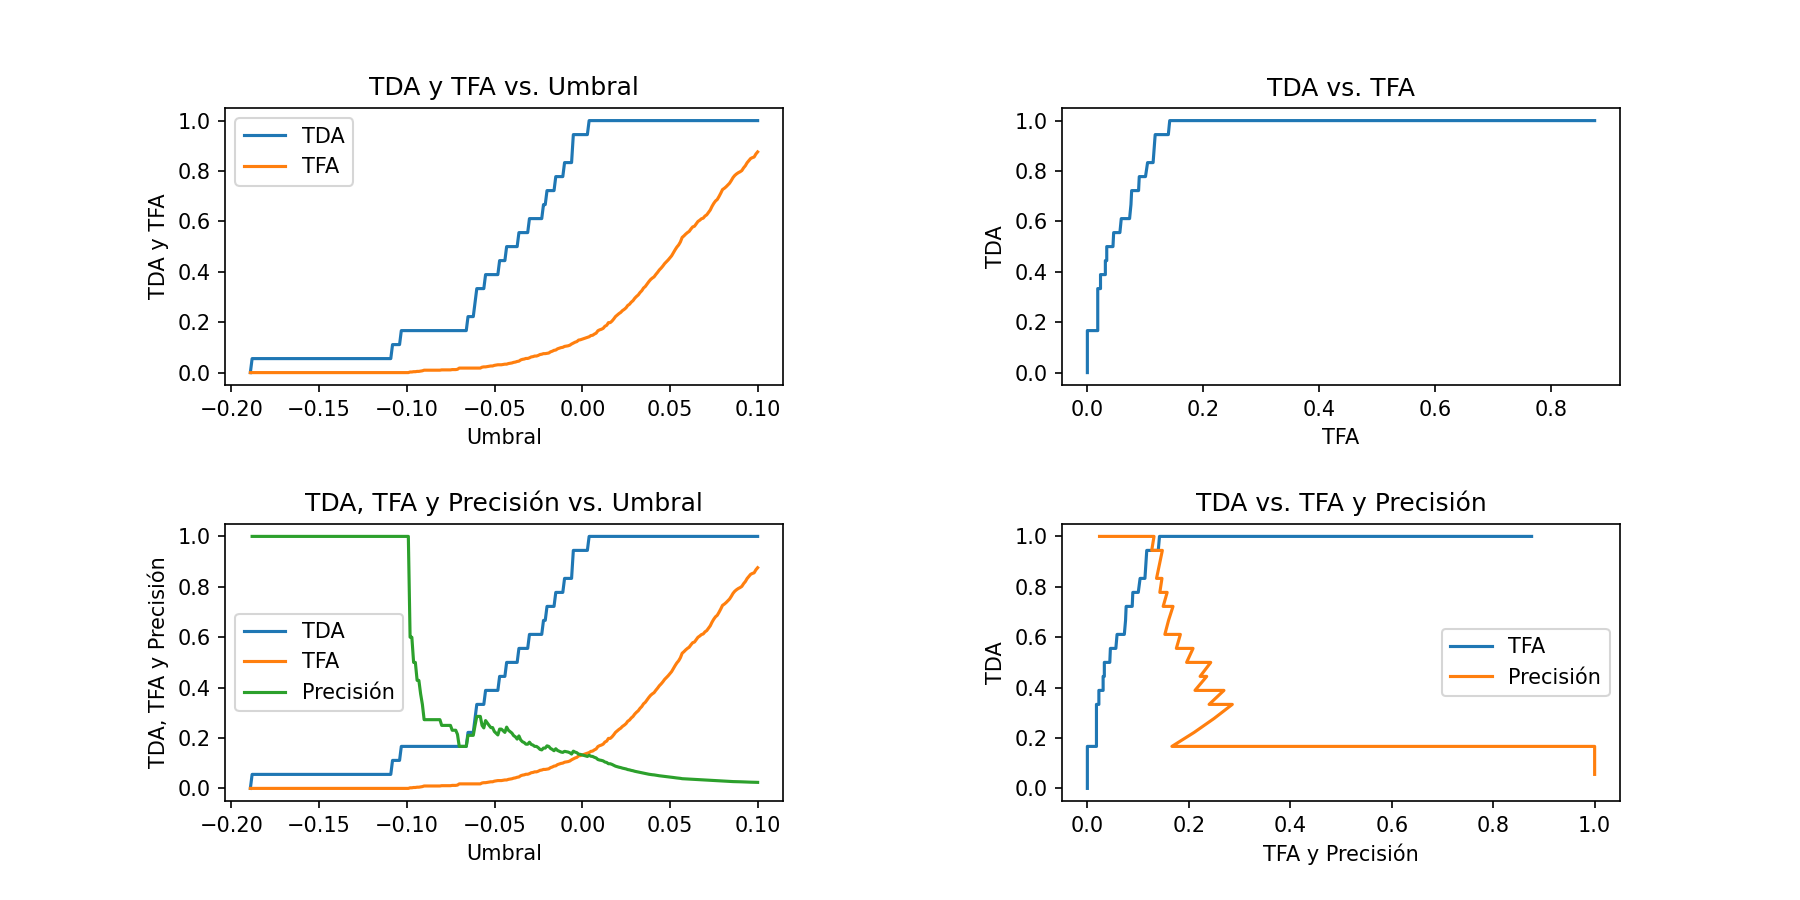

In [21]:
from sklearn.metrics import confusion_matrix

umbral = np.arange(np.min(scores_train), 0.1, 0.001)
tda=[]
tfa=[]
precis=[]

for i in range(len(umbral)):
    predicciones = np.where(scores_train < umbral[i], 1, 0)
    cm = confusion_matrix(etiq_verd_train, predicciones) 
    VP = cm[1, 1]
    FP = cm[0, 1]
    VN = cm[0, 0]
    FN = cm[1, 0]
    TDA= VP/(VP+FN) # Describe a la clase positiva (Clase Pos=VP+FN;Clase Neg=VN+FP)
    TFA=FP/(VN+FP)
    PREC=VP/(VP+FP) # Describe a las predicciones positivas correctas (PrediccPosit=VP+FP)
    tda.append(TDA)
    tfa.append(TFA)
    precis.append(PREC)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.plot(umbral, tda, label='TDA')
ax1.plot(umbral, tfa, label='TFA')
ax1.set_xlabel('Umbral')  
ax1.set_ylabel('TDA y TFA') 
ax1.set_title('TDA y TFA vs. Umbral')
ax1.legend()

ax2.plot(tfa, tda)
ax2.set_xlabel('TFA')  
ax2.set_ylabel('TDA')  
ax2.set_title('TDA vs. TFA')

ax3.plot(umbral, tda, label='TDA')
ax3.plot(umbral, tfa, label='TFA')
ax3.plot(umbral,precis,label='Precisión')
ax3.set_xlabel('Umbral')  
ax3.set_ylabel('TDA, TFA y Precisión') 
ax3.set_title('TDA, TFA y Precisión vs. Umbral')
ax3.legend()

ax4.plot(tfa,tda,label='TFA')
ax4.plot(precis, tda, label='Precisión')
ax4.set_xlabel('TFA y Precisión') 
ax4.set_ylabel('TDA') 
ax4.set_title('TDA vs. TFA y Precisión')
ax4.legend()

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

### Selección manual de valores de TDA y TFA

<IPython.core.display.Javascript object>


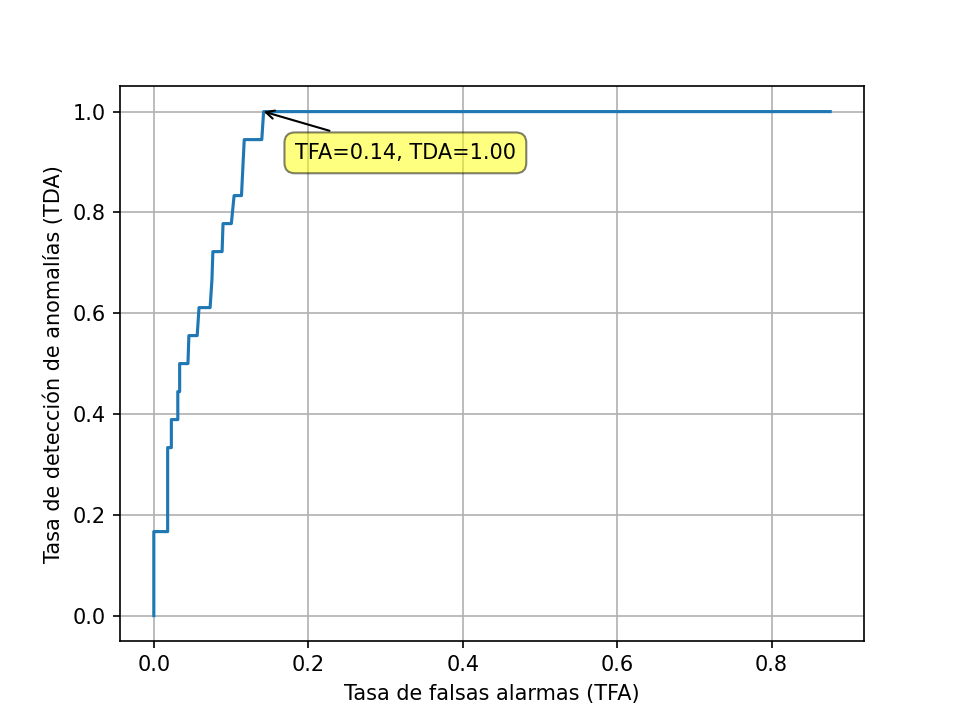

In [22]:
%matplotlib notebook
import mplcursors

fig, ax = plt.subplots()
ax.plot(tfa, tda)  
plt.xlabel('Tasa de falsas alarmas (TFA)')
plt.ylabel('Tasa de detección de anomalías (TDA)')
plt.grid(True)
# Habilitar la selección de puntos
cursor = mplcursors.cursor(ax, hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(f'TFA={sel.target[0]:.4f}, TDA={sel.target[1]:.1f}'))
cursor.connect("add", lambda sel: sel.annotation.draggable(True))
plt.show()

# Encontrar el menor valor de TFA cuando TDA es igual a 1
min_tfa = min([tfa[j] for j in range(len(tda)) if tda[j] == 1], default=np.nan)
print(f'(min TFA)/TDA=1: {min_tfa:.4f}')

### Cálculo del umbral, y resultados del entrenamiento (data_train)

In [23]:
from sklearn.metrics import classification_report

valor_tfa = input("Valor de TFA: ")
valor_tda = input("Valor de TDA: ")
valor_tfa=float(valor_tfa)
valor_tda=float(valor_tda)

def encontrar_indice_mas_cercano(tfa, tda, valor_tfa, valor_tda):
    distancias = []
    for i in range(len(tfa)):
        distancia = np.sqrt((tfa[i] - valor_tfa)**2 + (tda[i] - valor_tda)**2)
        distancias.append(distancia)
    indice_minimo = np.argmin(distancias)
    return indice_minimo

index_umb=encontrar_indice_mas_cercano(tfa, tda, valor_tfa, valor_tda)
umbral_dec=umbral[index_umb]
print ("Umbral para la decisión:", umbral_dec)
print("-----------------------------------------------------------------------")

anomalias = data_train[scores_train < umbral_dec]
print("Número de anomalías detectadas:", len(anomalias))
print("------------------------------------------------------------------------")

etiq_pred = np.where(scores_train < umbral_dec, 1, 0)
print(classification_report(etiq_verd_train, etiq_pred))
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_train, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)

Valor de TFA: 0.14
Valor de TDA: 1
Umbral para la decisión: 0.0038184469874845695
-----------------------------------------------------------------------
Número de anomalías detectadas: 137
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       837
           1       0.13      1.00      0.23        18

    accuracy                           0.86       855
   macro avg       0.57      0.93      0.58       855
weighted avg       0.98      0.86      0.91       855

------------------------------------------------------------------------
[[718 119]
 [  0  18]]
VP: 18
FP: 119
VN: 718
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.14217443249701314
Precision: 0.13138686131386862
F1: 0.23225806451612904


### Análisis y resultados en la validación (data_test)

<IPython.core.display.Javascript object>


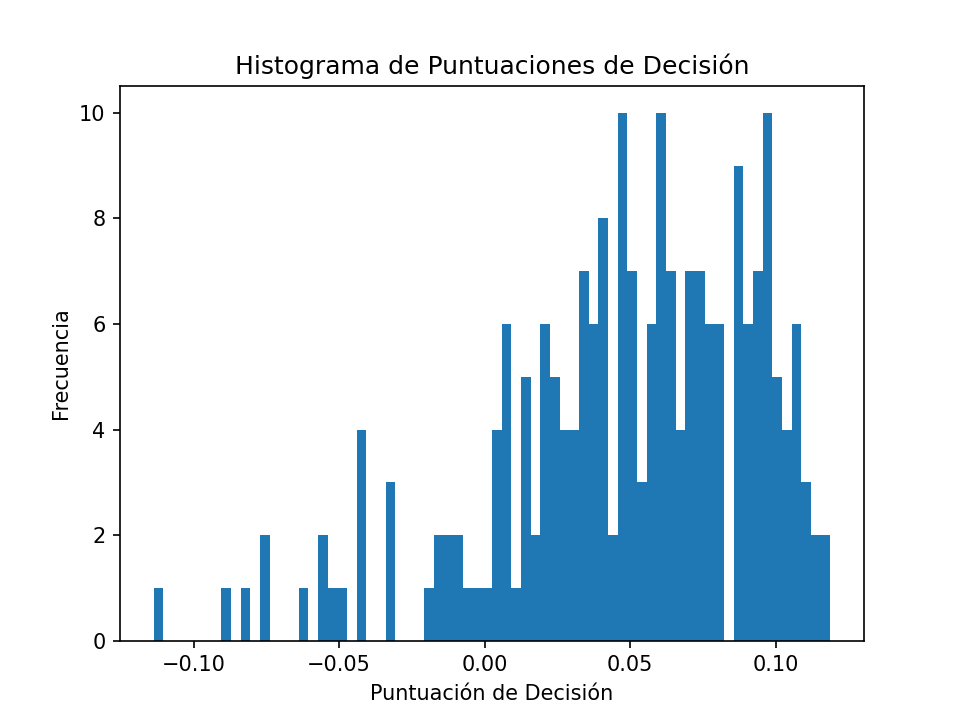

Número de anomalías detectadas: 28
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       204
           1       0.36      1.00      0.53        10

    accuracy                           0.92       214
   macro avg       0.68      0.96      0.74       214
weighted avg       0.97      0.92      0.93       214

------------------------------------------------------------------------
[[186  18]
 [  0  10]]
VP: 10
FP: 18
VN: 186
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.08823529411764706
Precision: 0.35714285714285715
F1: 0.5263157894736842


In [24]:
scores_test = iForest.decision_function(data_test)

plt.hist(scores_test, bins=70)
plt.xlabel('Puntuación de Decisión')
plt.ylabel('Frecuencia')
plt.title('Histograma de Puntuaciones de Decisión')
plt.show()

anomalias = data_test[scores_test < umbral_dec]
print("Número de anomalías detectadas:", len(anomalias))
print("------------------------------------------------------------------------")

etiq_pred = np.where(scores_test < umbral_dec, 1, 0)
print(classification_report(etiq_verd_test, etiq_pred))
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_test, etiq_pred)
print(cm)
VP = cm[1, 1] 
FP = cm[0, 1] 
VN = cm[0, 0] 
FN = cm[1, 0]
print("VP:",VP) 
print("FP:",FP) 
print("VN:",VN) 
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN) 
TFA=FP/(VN+FP) 
Precision=VP/(VP+FP) 
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)

#### Mostrar cada gráfico por separado

<IPython.core.display.Javascript object>


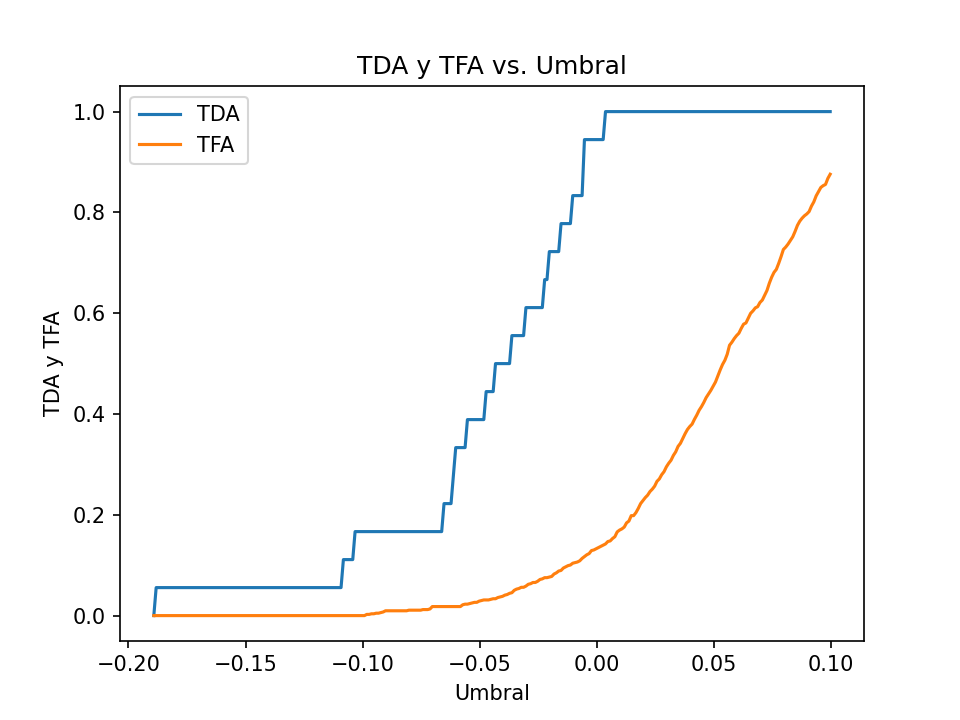

<IPython.core.display.Javascript object>


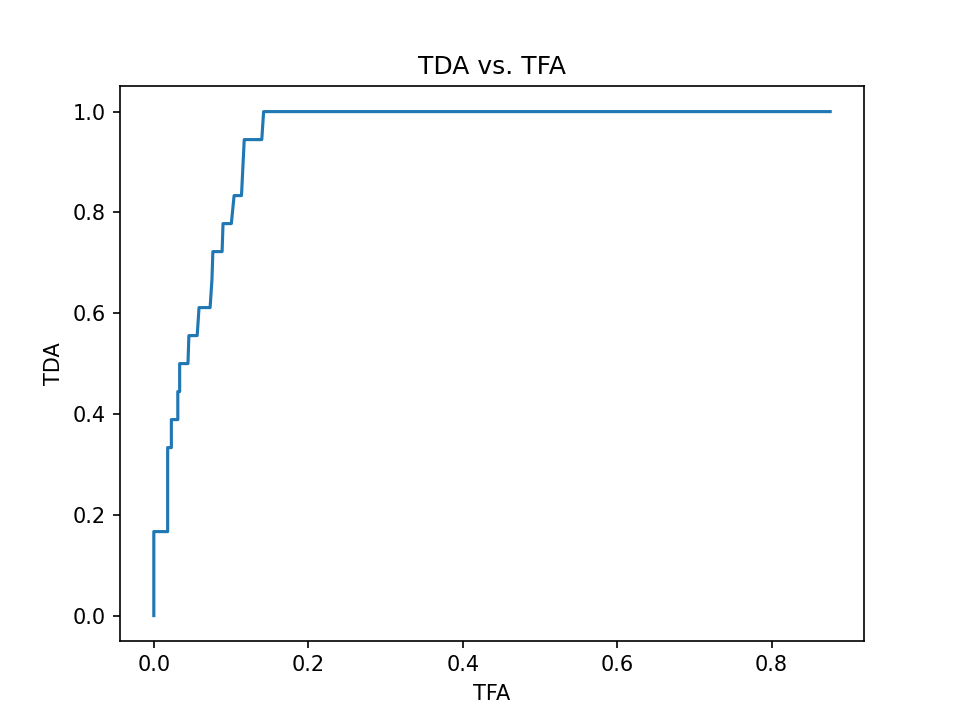

<IPython.core.display.Javascript object>


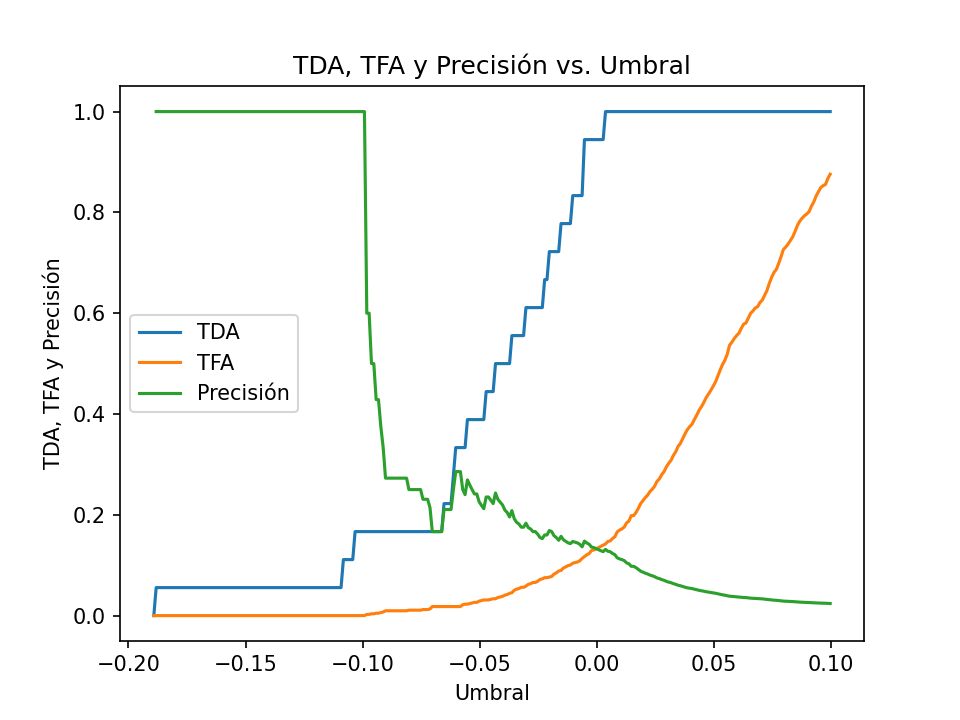

<IPython.core.display.Javascript object>


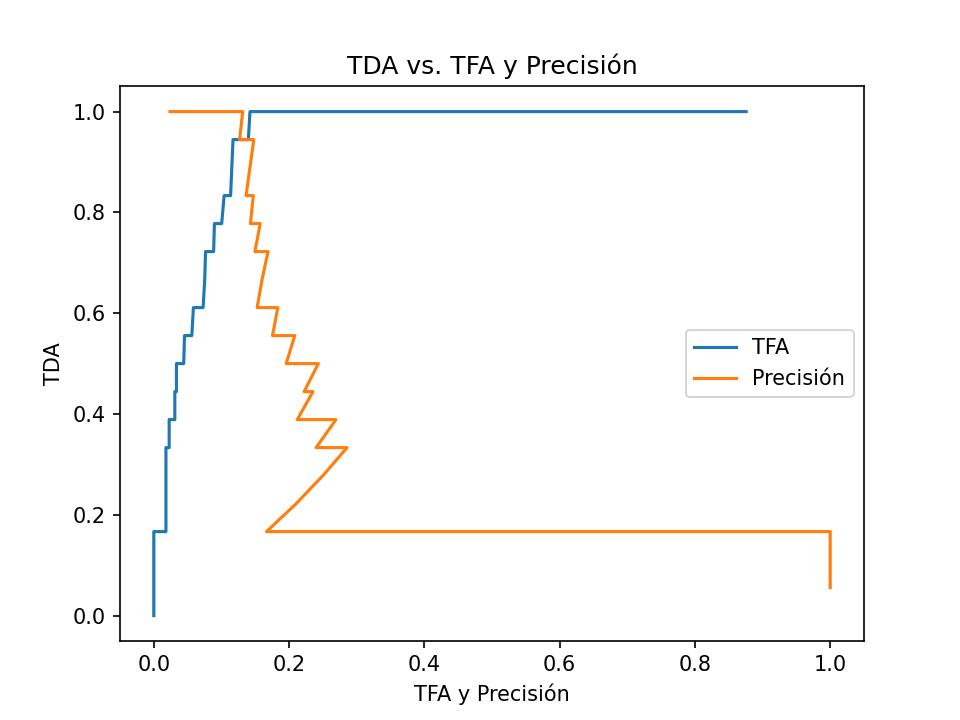

In [16]:
import matplotlib.pyplot as plt

# Supongamos que 'axes' es tu array de subplots originales
figures = []

# Graficar los tres gráficos originales por separado
for i, ax in enumerate(axes.flatten(), start=1):
    fig, new_ax = plt.subplots()
    for line in ax.get_lines():
        new_ax.plot(line.get_xdata(), line.get_ydata(), label=line.get_label())
    new_ax.set_title(ax.get_title())
    new_ax.set_xlabel(ax.get_xlabel())
    new_ax.set_ylabel(ax.get_ylabel())
    if i == 1 or i == 3 or i == 4:
        new_ax.legend()
    figures.append(fig)
    plt.show()

#### Graficar una línea horizontal para ajuste fino del umbral

<IPython.core.display.Javascript object>


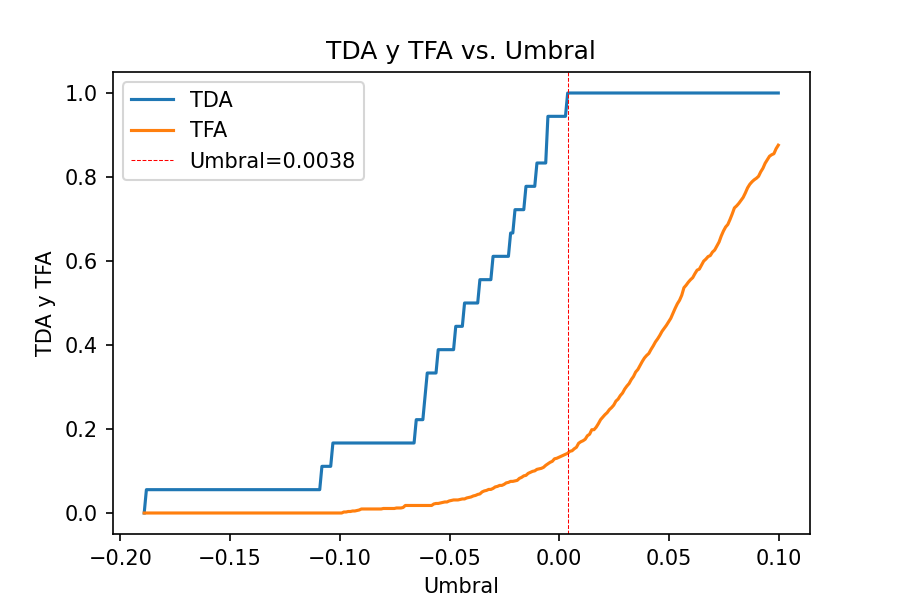

<IPython.core.display.Javascript object>


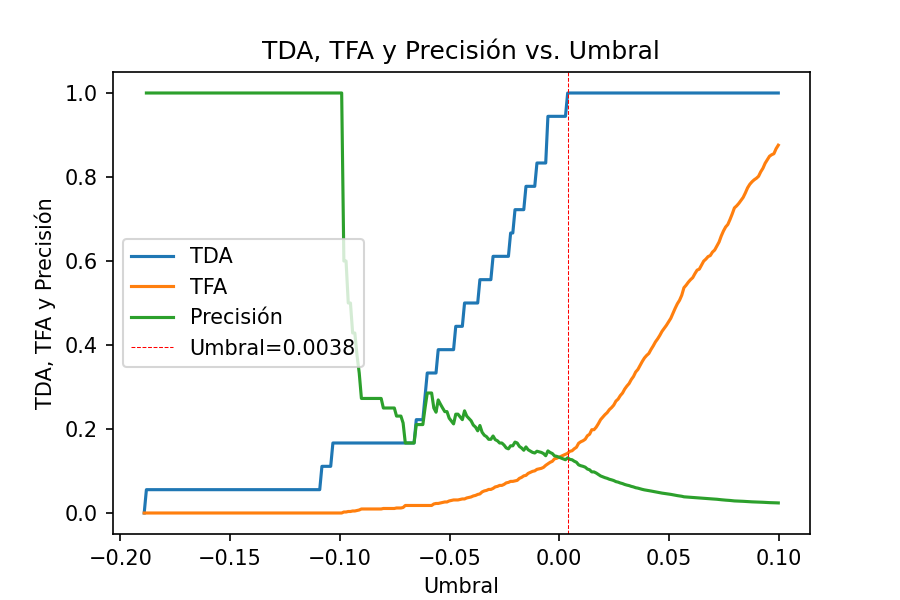

In [44]:
# Crear el gráfico
plt.figure(figsize=(6, 4))
plt.plot(umbral, tda, label='TDA')
plt.plot(umbral, tfa, label='TFA')
plt.xlabel('Umbral')
plt.ylabel('TDA y TFA')
plt.title('TDA y TFA vs. Umbral')
plt.legend()
# Agregar líneas verticales discontinuas
plt.axvline(x=umbral_dec, color='r', linestyle='--', linewidth=0.5, label=f'Umbral={umbral_dec:.4f}')
plt.legend()
plt.show()

# Crear el gráfico
plt.figure(figsize=(6, 4))
plt.plot(umbral, tda, label='TDA')
plt.plot(umbral, tfa, label='TFA')
plt.plot(umbral,precis,label='Precisión')
plt.xlabel('Umbral')  
plt.ylabel('TDA, TFA y Precisión') 
plt.title('TDA, TFA y Precisión vs. Umbral')
plt.legend()
# Agregar líneas verticales discontinuas
plt.axvline(x=umbral_dec, color='r', linestyle='--', linewidth=0.5, label=f'Umbral={umbral_dec:.4f}')
plt.legend()
plt.show()

### Ajuste fino del umbral
#### Valor definitivo de Umbral=0.00318

In [40]:
umbral_fino = input("Valor del umbral:")
umbral_fino=float(umbral_fino)

print(" \n  \n ---------------- Datos de entrenamiento ----------------------------- \n ")
anomalias = data_train[scores_train < umbral_fino]
print("Número de anomalías detectadas:", len(anomalias))


etiq_pred = np.where(scores_train < umbral_fino, 1, 0)
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_train, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)

print(" \n  \n ---------------- Datos de validación --------------------------- \n ")
anomalias = data_test[scores_test < umbral_fino]
print("Número de anomalías detectadas:", len(anomalias))


etiq_pred = np.where(scores_test < umbral_fino, 1, 0)
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_test, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)


Valor del umbral:0.00318
 
  
 ---------------- Datos de entrenamiento ----------------------------- 
 
Número de anomalías detectadas: 135
------------------------------------------------------------------------
[[720 117]
 [  0  18]]
VP: 18
FP: 117
VN: 720
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.13978494623655913
Precision: 0.13333333333333333
F1: 0.23529411764705882
 
  
 ---------------- Datos de validación --------------------------- 
 
Número de anomalías detectadas: 27
------------------------------------------------------------------------
[[187  17]
 [  0  10]]
VP: 10
FP: 17
VN: 187
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.08333333333333333
Precision: 0.37037037037037035
F1: 0.5405405405405406
